In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import seaborn as sns   

In [3]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset
print("Customers Data:")
print(customers.head())
print("\nProducts Data:")
print(products.head())
print("\nTransactions Data:")
print(transactions.head())

Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127 

In [4]:
# Merge datasets to create a unified dataset
# Merge transactions with customers on CustomerID
data = pd.merge(transactions, customers, on='CustomerID')

# Merge the resulting data with products on ProductID
data = pd.merge(data, products, on='ProductID')

# Display the merged dataset
print("\nMerged Data:")
print(data.head())


Merged Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Blu

In [5]:
# Feature Engineering
# Create features for customer behavior
# 1. Total spending per customer
customer_spending = data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spending.rename(columns={'TotalValue': 'TotalSpending'}, inplace=True)

# 2. Number of transactions per customer
customer_transactions = data.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_transactions.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)

# 3. Average transaction value per customer
customer_avg_value = data.groupby('CustomerID')['TotalValue'].mean().reset_index()
customer_avg_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

# 4. Favorite product category (most purchased category)
customer_favorite_category = data.groupby(['CustomerID', 'Category']).size().reset_index(name='CategoryCount')
customer_favorite_category = customer_favorite_category.loc[customer_favorite_category.groupby('CustomerID')['CategoryCount'].idxmax()]
customer_favorite_category = customer_favorite_category[['CustomerID', 'Category']]
customer_favorite_category.rename(columns={'Category': 'FavoriteCategory'}, inplace=True)


In [6]:
# Merge all features into a single customer profile dataset
customer_profile = pd.merge(customer_spending, customer_transactions, on='CustomerID')
customer_profile = pd.merge(customer_profile, customer_avg_value, on='CustomerID')
customer_profile = pd.merge(customer_profile, customer_favorite_category, on='CustomerID')

# Add customer demographic information (from Customers.csv)
customer_profile = pd.merge(customer_profile, customers, on='CustomerID')

# Display the final customer profile dataset
print("\nCustomer Profile Data:")
print(customer_profile.head())


Customer Profile Data:
  CustomerID  TotalSpending  TransactionCount  AvgTransactionValue  \
0      C0001        3354.52                 5              670.904   
1      C0002        1862.74                 4              465.685   
2      C0003        2725.38                 4              681.345   
3      C0004        5354.88                 8              669.360   
4      C0005        2034.24                 3              678.080   

  FavoriteCategory        CustomerName         Region  SignupDate  
0      Electronics    Lawrence Carroll  South America  2022-07-10  
1         Clothing      Elizabeth Lutz           Asia  2022-02-13  
2       Home Decor      Michael Rivera  South America  2024-03-07  
3            Books  Kathleen Rodriguez  South America  2022-10-09  
4      Electronics         Laura Weber           Asia  2022-08-15  


In [7]:
# Preprocessing for clustering
# Separate numerical and categorical features
numerical_features = ['TotalSpending', 'TransactionCount', 'AvgTransactionValue']
categorical_features = ['FavoriteCategory', 'Region']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Apply preprocessing to the customer profile data
customer_features = preprocessor.fit_transform(customer_profile)

In [8]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
db_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(customer_features, kmeans.labels_))

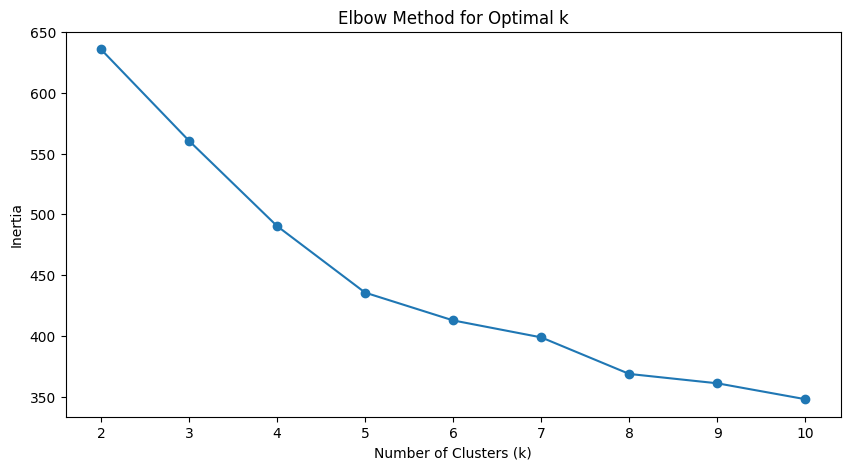

In [9]:
# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

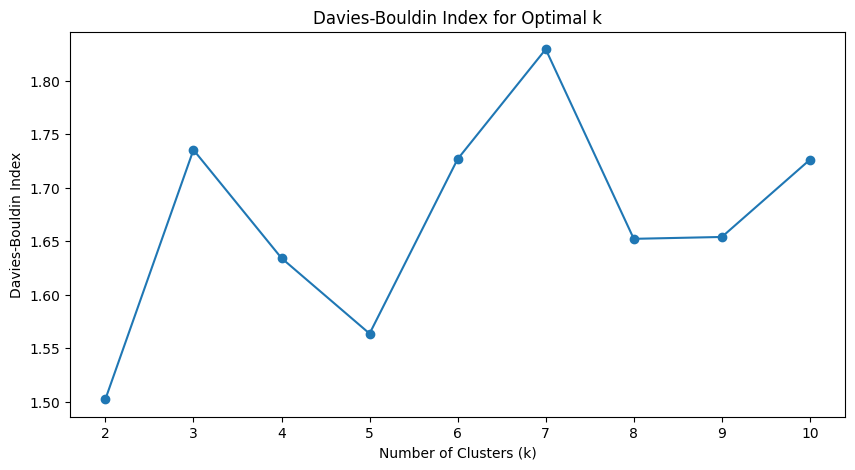

In [10]:
# Plot the Davies-Bouldin Index graph
plt.figure(figsize=(10, 5))
plt.plot(k_values, db_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal k')
plt.show()

In [11]:
# Choose the optimal number of clusters (e.g., k=4 based on the Elbow Method and DB Index)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(customer_features)

# Add cluster labels to the customer profile dataset
customer_profile['Cluster'] = kmeans.labels_

# Display the clustered customer profile dataset
print("\nClustered Customer Profile Data:")
print(customer_profile.head())


Clustered Customer Profile Data:
  CustomerID  TotalSpending  TransactionCount  AvgTransactionValue  \
0      C0001        3354.52                 5              670.904   
1      C0002        1862.74                 4              465.685   
2      C0003        2725.38                 4              681.345   
3      C0004        5354.88                 8              669.360   
4      C0005        2034.24                 3              678.080   

  FavoriteCategory        CustomerName         Region  SignupDate  Cluster  
0      Electronics    Lawrence Carroll  South America  2022-07-10        1  
1         Clothing      Elizabeth Lutz           Asia  2022-02-13        2  
2       Home Decor      Michael Rivera  South America  2024-03-07        1  
3            Books  Kathleen Rodriguez  South America  2022-10-09        0  
4      Electronics         Laura Weber           Asia  2022-08-15        1  



Davies-Bouldin Index: 1.6342071034302736


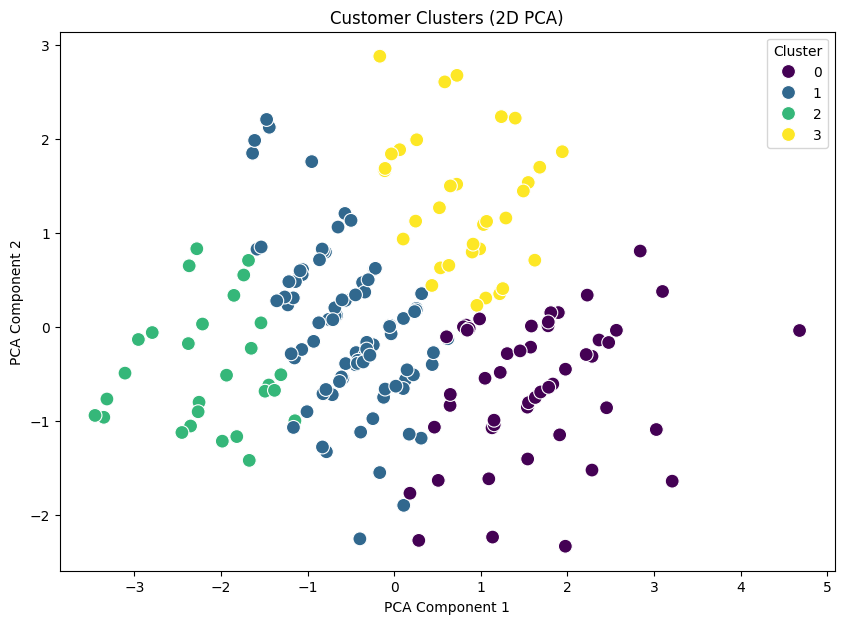

In [12]:
# Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(customer_features, kmeans.labels_)
print(f"\nDavies-Bouldin Index: {db_index}")

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features.toarray() if hasattr(customer_features, 'toarray') else customer_features)

# Add PCA components to the customer profile dataset
customer_profile['PCA1'] = customer_features_pca[:, 0]
customer_profile['PCA2'] = customer_features_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_profile, palette='viridis', s=100)
plt.title('Customer Clusters (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [14]:
# Save the clustered customer profile dataset to a CSV file
customer_profile.to_csv('Clustered_Customers.csv', index=False)

In [15]:
# Display the final output
print("\nClustering Results:")
print(customer_profile[['CustomerID', 'Cluster']].head())


Clustering Results:
  CustomerID  Cluster
0      C0001        1
1      C0002        2
2      C0003        1
3      C0004        0
4      C0005        1
